In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
from matplotlib.widgets import Slider

# Quadrupole 

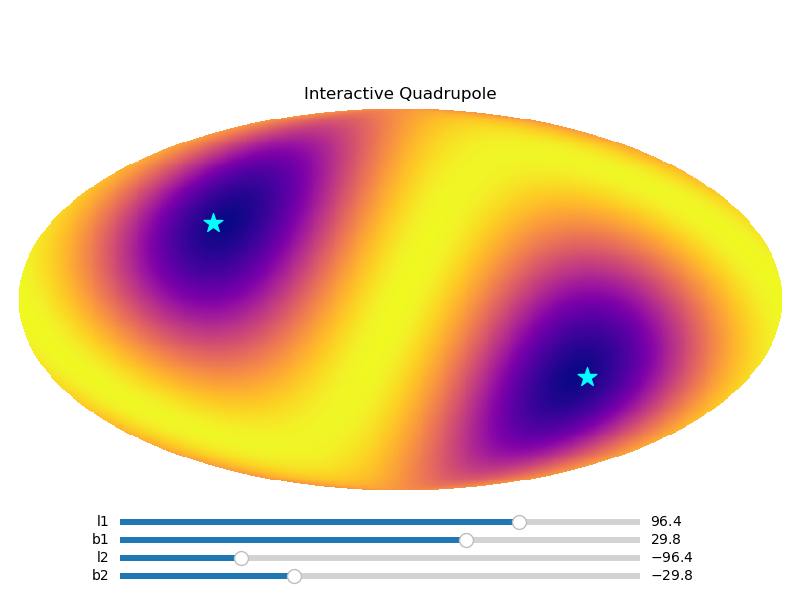

In [3]:
# Interactive figure, quadrupole
%matplotlib widget
NSIDE = 128
NPIX = hp.nside2npix(NSIDE)
Q = 0.014

def update(val):
    
    l1 = s_l1.val
    b1 = s_b1.val
    l2 = s_l2.val
    b2 = s_b2.val

    theta1, phi1 = np.deg2rad(90 - b1), np.deg2rad(l1)
    theta2, phi2 = np.deg2rad(90 - b2), np.deg2rad(l2)

    a = hp.ang2vec(theta1, phi1)
    b = hp.ang2vec(theta2, phi2)

    Q_prime = np.outer(a, b)
    Q_star = 0.5 * (Q_prime + Q_prime.T)
    Q_hat = Q_star - (np.trace(Q_star)/3) * np.eye(3)

    pixels = hp.pix2vec(NSIDE, np.arange(NPIX))
    f = Q * np.einsum('ij,i...,j...', Q_hat, pixels, pixels)
    m_q = 1 + f

    hp.mollview(m_q, fig=fig.number, cmap='plasma', title="Interactive Quadrupole", hold=False, cbar=False)
    hp.projscatter(theta1, phi1, lonlat=False, marker='*', s=200, color='cyan')
    hp.projscatter(theta2, phi2, lonlat=False, marker='*', s=200, color='cyan')

l1_init, b1_init = 96.38, 29.81
l2_init, b2_init = -96.38, -29.81

# Figures
fig = plt.figure(figsize=(8, 6))
axcolor = 'lightgoldenrodyellow'
ax_l1 = plt.axes([0.15, 0.12, 0.65, 0.02], facecolor=axcolor)
ax_b1 = plt.axes([0.15, 0.09, 0.65, 0.02], facecolor=axcolor)
ax_l2 = plt.axes([0.15, 0.06, 0.65, 0.02], facecolor=axcolor)
ax_b2 = plt.axes([0.15, 0.03, 0.65, 0.02], facecolor=axcolor)

# Sliders
s_l1 = Slider(ax_l1, 'l1', -180, 180, valinit=l1_init)
s_b1 = Slider(ax_b1, 'b1', -90, 90, valinit=b1_init)
s_l2 = Slider(ax_l2, 'l2', -180, 180, valinit=l2_init)
s_b2 = Slider(ax_b2, 'b2', -90, 90, valinit=b2_init)

# Updates
s_l1.on_changed(update)
s_b1.on_changed(update)
s_l2.on_changed(update)
s_b2.on_changed(update)

update(None)
plt.show()

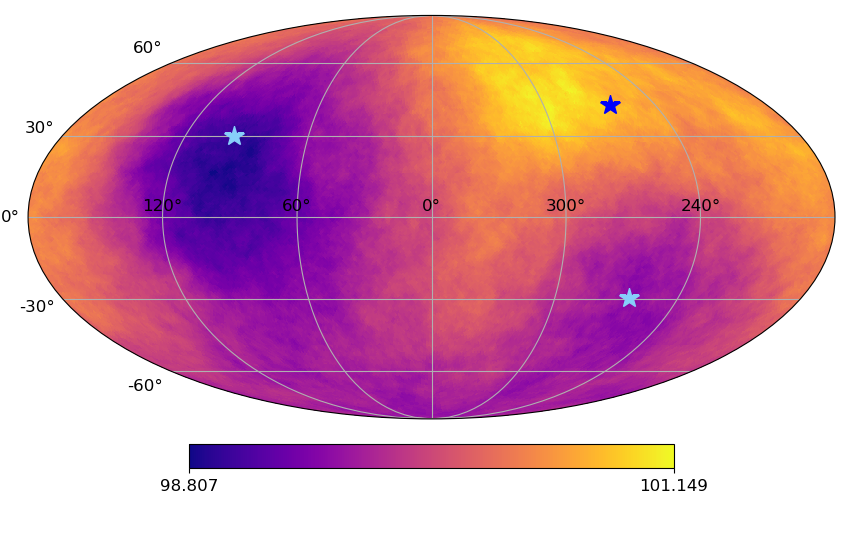

In [3]:
# Dipole sampling
from my_functions import *
from healpy.newvisufunc import projview, newprojplot
def dipole_quad_sampling(NSIDE, N_bar, D, Q, d_vector, q_vector_1, q_vector_2):
    NPIX = hp.nside2npix(NSIDE)
    dipole_theta, dipole_phi = d_vector[0], d_vector[1]
    dipole_vec = hp.ang2vec(dipole_theta, dipole_phi) # (x, y, z) from (b, l) shape (1, 3)

    pixels = np.vstack(hp.pix2vec(NSIDE, np.arange(NPIX))) # shape (3, NPIX)
    
    dot_product = np.dot(dipole_vec, pixels)  # returns shape (NPIX, )
    angles = np.arccos(dot_product) # shape (NPIX, )
    dipole_signal = D*np.cos(angles) # shape (NPIX, )
    
    # Quadrupole tensor
    b1, l1 = q_vector_1[0], q_vector_1[1]
    b2, l2 = q_vector_2[0], q_vector_2[1]
    
    # Constructing quadrupole tensor using the outer product of the 2 vectors
    v1 = hp.ang2vec(b1, l1)
    v2 = hp.ang2vec(b2, l2)
    Q_prime = np.outer(v1, v2)
    Q_star = 1/2 * (Q_prime + Q_prime.T)
    Q_hat = Q_star - (np.trace(Q_star)/3 * np.eye(3))

    # Quadrupole signal
    quad_signal = Q*np.einsum('ij,i...,j...', Q_hat, pixels, pixels)
    
    lambda_ = N_bar * (1 + dipole_signal + quad_signal)
    sample = np.random.poisson(lambda_)
    
    return sample, lambda_

NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
D = 0.007
Q = 0.014
dipole_theta = np.deg2rad(48) # CMB Directions (b)
dipole_phi = -np.deg2rad(360-264) # (l)
# Set the quadrupole vectors to both point at the CMB dipole direction
q_vector_1 = [np.deg2rad(90-29.81), np.deg2rad(96.38)]  # b1, l1 north ecliptic pole
q_vector_2 = [np.deg2rad(90+29.81), np.deg2rad(-96.38)]  # b2, l2 south ecliptic pole

m, lambda_ = dipole_quad_sampling(NSIDE, N_bar=100, D=D, Q=Q,
                                            d_vector=[dipole_theta, dipole_phi],
                                            q_vector_1=q_vector_1, q_vector_2=q_vector_2)
smooth_map = compute_smooth_map(m, angle_scale=1)
dipole_quad_plotting(smooth_map, d_vector=[dipole_theta, dipole_phi], q_vector_1=q_vector_1, q_vector_2=q_vector_2, title=None, unit=None, cmap='plasma')

# Dipole and Quadrupole 

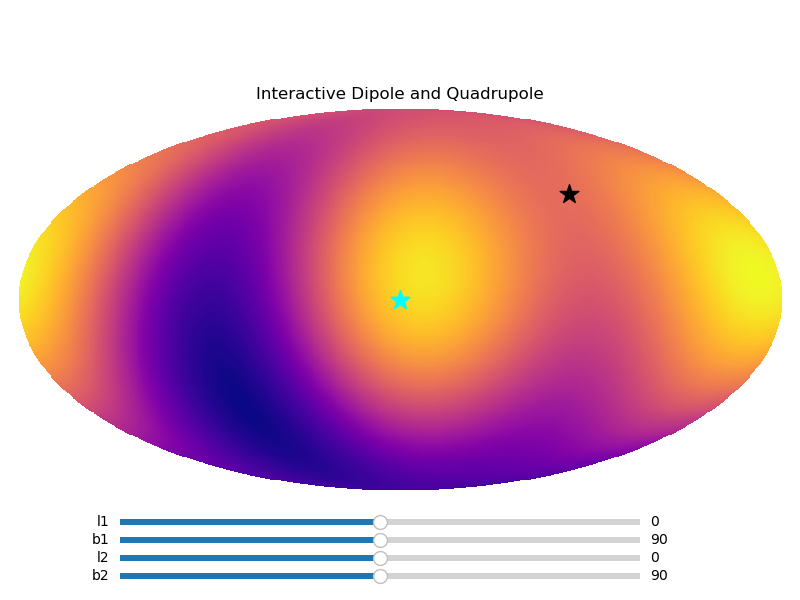

In [4]:
# Interactive figure, dipole with quadrupole
%matplotlib widget
NSIDE = 128
NPIX = hp.nside2npix(NSIDE)
Q = 0.014
D = 0.007 
x,y,z = hp.pix2vec(NSIDE, np.arange(NPIX))
dipole_theta = np.deg2rad(48)
dipole_phi = -np.deg2rad(360-264)

x_dip, y_dip, z_dip = hp.ang2vec(dipole_theta, dipole_phi)
pixels = np.array([x, y, z])
dipole_vec = np.array([x_dip,y_dip,z_dip])
dot_product = np.dot(dipole_vec, pixels)
angles = np.arccos(dot_product)
m_d = D*np.cos(angles)

def update(val):
    l1 = s_l1.val
    b1 = s_b1.val
    l2 = s_l2.val
    b2 = s_b2.val

    theta1, phi1 = np.deg2rad(b1), np.deg2rad(l1)
    theta2, phi2 = np.deg2rad(b2), np.deg2rad(l2)

    a = hp.ang2vec(theta1, phi1)
    b = hp.ang2vec(theta2, phi2)

    Q_prime = np.outer(a, b)
    Q_star = 0.5 * (Q_prime + Q_prime.T)
    Q_hat = Q_star - (np.trace(Q_star)/3) * np.eye(3)

    pixels = hp.pix2vec(NSIDE, np.arange(NPIX))
    f = Q * np.einsum('ij,i...,j...', Q_hat, pixels, pixels)
    m_q = 1 + m_d + f

    hp.mollview(m_q, fig=fig.number, cmap='plasma', title="Interactive Dipole and Quadrupole", hold=False, cbar=False)
    hp.projscatter(dipole_theta, dipole_phi, lonlat=False, marker='*', s=200, color='k')
    hp.projscatter(theta1, phi1, lonlat=False, marker='*', s=200, color='cyan')
    hp.projscatter(theta2, phi2, lonlat=False, marker='*', s=200, color='cyan')
    

l1_init, b1_init = 0, 90
l2_init, b2_init = 0, 90

# Figure
fig = plt.figure(figsize=(8, 6))
axcolor = 'lightgoldenrodyellow'
ax_l1 = plt.axes([0.15, 0.12, 0.65, 0.02], facecolor=axcolor)
ax_b1 = plt.axes([0.15, 0.09, 0.65, 0.02], facecolor=axcolor)
ax_l2 = plt.axes([0.15, 0.06, 0.65, 0.02], facecolor=axcolor)
ax_b2 = plt.axes([0.15, 0.03, 0.65, 0.02], facecolor=axcolor)

# Sliders
s_l1 = Slider(ax_l1, 'l1', -180, 180, valinit=l1_init)
s_b1 = Slider(ax_b1, 'b1', 0, 180, valinit=b1_init)
s_l2 = Slider(ax_l2, 'l2', -180, 180, valinit=l2_init)
s_b2 = Slider(ax_b2, 'b2', 0, 180, valinit=b2_init)

# Updates
s_l1.on_changed(update)
s_b1.on_changed(update)
s_l2.on_changed(update)
s_b2.on_changed(update)

update(None)
plt.show()

# Gradient of the signal 

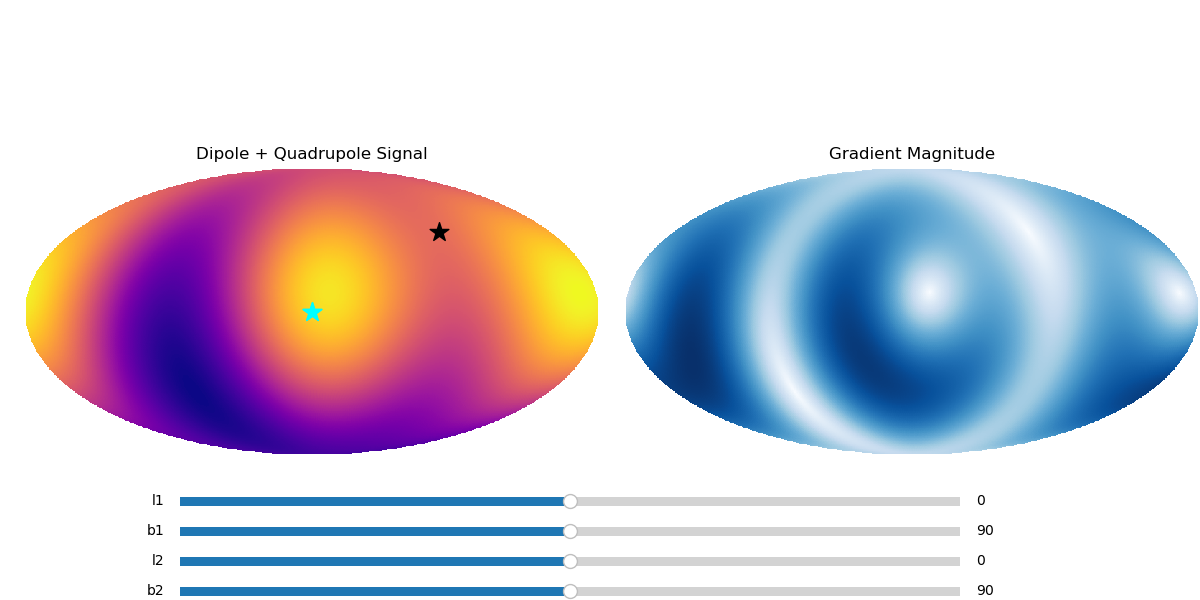

In [5]:
%matplotlib widget

NSIDE = 128
NPIX = hp.nside2npix(NSIDE)
Q = 0.014
D = 0.007

def dipole_quadrupole_signal_and_gradient(NSIDE, D, Q, dipole_vec, vector_1, vector_2):
    NPIX = hp.nside2npix(NSIDE)
    pixels = np.vstack(hp.pix2vec(NSIDE, np.arange(NPIX)))  # (3, NPIX)

    # Dipole term
    dipole_term = np.dot(dipole_vec, pixels)  # shape (NPIX,)
    dipole_signal = D * dipole_term

    # Quadrupole tensor
    a = hp.ang2vec(vector_1[0], vector_1[1])
    b = hp.ang2vec(vector_2[0], vector_2[1])
    Q_prime = np.outer(a, b)
    Q_star = 0.5 * (Q_prime + Q_prime.T)
    Q_hat = Q_star - (np.trace(Q_star) / 3.0) * np.eye(3)

    # Quadrupole term
    quad_term = np.einsum('ij,i...,j...', Q_hat, pixels, pixels)
    quad_signal = Q * quad_term

    # Total signal
    total_signal = 1 + dipole_signal + quad_signal

    # Gradient calculations
    grad_dip_cart = D * dipole_vec[:, None]
    grad_dip_proj = grad_dip_cart - (D * dipole_term) * pixels

    grad_quad_cart = 2 * Q * (Q_hat @ pixels)
    grad_quad_proj = grad_quad_cart - (2 * Q * quad_term) * pixels

    grad_proj = grad_dip_proj + grad_quad_proj
    grad_mag = np.linalg.norm(grad_proj, axis=0)

    return total_signal, grad_mag

# Create a single figure with two subplots side-by-side
fig, (ax_signal, ax_grad) = plt.subplots(1, 2, figsize=(12, 6),
                                         subplot_kw=dict(projection='mollweide'))

# Turn off default axis ticks and labels for healpy style plotting
for ax in (ax_signal, ax_grad):
    ax.set_frame_on(False)      # Remove border
    ax.set_xticks([])           # No x ticks
    ax.set_yticks([])           # No y ticks
    ax.set_xlabel('')
    ax.set_ylabel('')

# Slider axes below the figure
fig.subplots_adjust(bottom=0.25)
axcolor = 'lightgoldenrodyellow'
ax_l1 = fig.add_axes([0.15, 0.15, 0.65, 0.03], facecolor=axcolor)
ax_b1 = fig.add_axes([0.15, 0.10, 0.65, 0.03], facecolor=axcolor)
ax_l2 = fig.add_axes([0.15, 0.05, 0.65, 0.03], facecolor=axcolor)
ax_b2 = fig.add_axes([0.15, 0.00, 0.65, 0.03], facecolor=axcolor)

s_l1 = Slider(ax_l1, 'l1', -180, 180, valinit=0)
s_b1 = Slider(ax_b1, 'b1', 0, 180, valinit=90)
s_l2 = Slider(ax_l2, 'l2', -180, 180, valinit=0)
s_b2 = Slider(ax_b2, 'b2', 0, 180, valinit=90)

dipole_theta = np.deg2rad(48)
dipole_phi = -np.deg2rad(360-264)
dipole_vec = np.array(hp.ang2vec(dipole_theta, dipole_phi))

def update(val):
    l1 = s_l1.val
    b1 = s_b1.val
    l2 = s_l2.val
    b2 = s_b2.val

    theta1, phi1 = np.deg2rad(b1), np.deg2rad(l1)
    theta2, phi2 = np.deg2rad(b2), np.deg2rad(l2)

    m_signal, grad_mag = dipole_quadrupole_signal_and_gradient(
        NSIDE, D, Q, dipole_vec,
        (theta1, phi1), (theta2, phi2)
    )

    # Clear axes for redraw
    ax_signal.cla()
    ax_grad.cla()

    # Plot signal map on left
    hp.mollview(m_signal, fig=fig.number, cmap='plasma', title='Dipole + Quadrupole Signal',
                hold=False, sub=(1, 2, 1), cbar=False, coord=None, notext=True, min=min(m_signal), max=max(m_signal))

    ax_signal.grid(False)
    ax_signal.set_xticklabels([])
    ax_signal.set_yticklabels([])

    # Overlay stars on signal map
    hp.projscatter(dipole_theta, dipole_phi, lonlat=False, marker='*', s=200, color='k')
    hp.projscatter(theta1, phi1, lonlat=False, marker='*', s=200, color='cyan')
    hp.projscatter(theta2, phi2, lonlat=False, marker='*', s=200, color='cyan')

    # Plot gradient magnitude on right
    hp.mollview(grad_mag, fig=fig.number, cmap='Blues', title='Gradient Magnitude',
                hold=False, sub=(1, 2, 2), cbar=False, coord=None, notext=True,min=min(grad_mag), max=max(grad_mag))
    ax_grad.grid(False)
    ax_grad.set_xticklabels([])
    ax_grad.set_yticklabels([])

s_l1.on_changed(update)
s_b1.on_changed(update)
s_l2.on_changed(update)
s_b2.on_changed(update)

update(None)
plt.show()

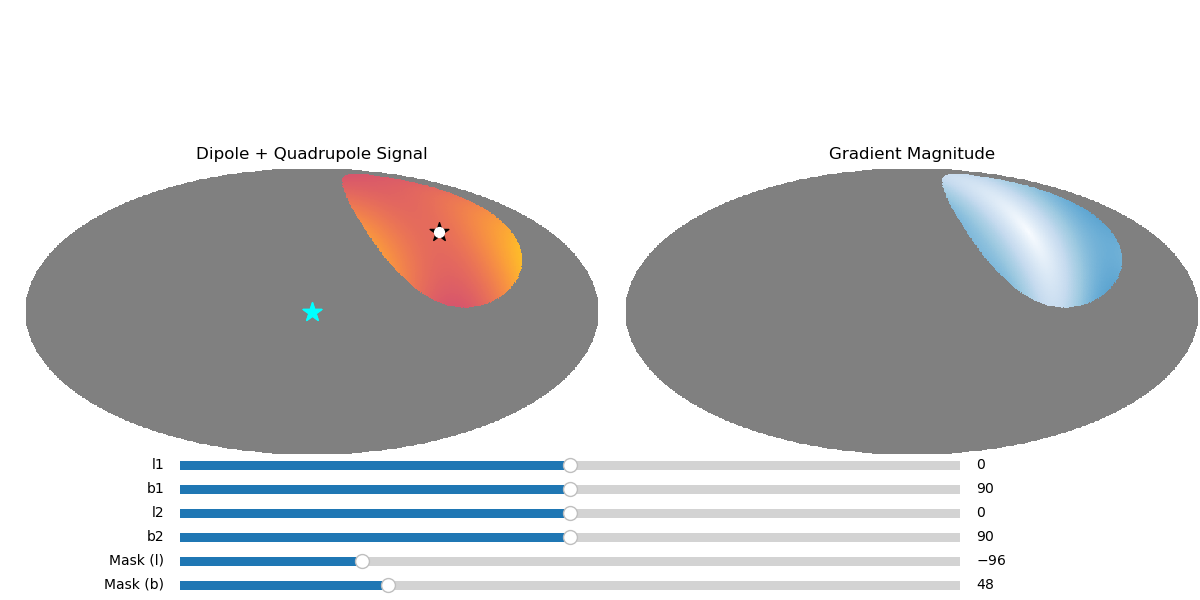

In [5]:
%matplotlib widget

NSIDE = 128
NPIX = hp.nside2npix(NSIDE)
Q = 0.014
D = 0.007

def dipole_quadrupole_signal_and_gradient(NSIDE, D, Q, dipole_vec, vector_1, vector_2):
    NPIX = hp.nside2npix(NSIDE)
    pixels = np.vstack(hp.pix2vec(NSIDE, np.arange(NPIX)))  # (3, NPIX)

    # Dipole term
    dipole_term = np.dot(dipole_vec, pixels)  # shape (NPIX,)
    dipole_signal = D * dipole_term

    # Quadrupole tensor
    a = hp.ang2vec(vector_1[0], vector_1[1])
    b = hp.ang2vec(vector_2[0], vector_2[1])
    Q_prime = np.outer(a, b)
    Q_star = 0.5 * (Q_prime + Q_prime.T)
    Q_hat = Q_star - (np.trace(Q_star) / 3.0) * np.eye(3)

    # Quadrupole term
    quad_term = np.einsum('ij,i...,j...', Q_hat, pixels, pixels)
    quad_signal = Q * quad_term

    # Total signal
    total_signal = 1 + dipole_signal + quad_signal

    # Gradient calculations
    grad_dip_cart = D * dipole_vec[:, None]
    grad_dip_proj = grad_dip_cart - (D * dipole_term) * pixels

    grad_quad_cart = 2 * Q * (Q_hat @ pixels)
    grad_quad_proj = grad_quad_cart - (2 * Q * quad_term) * pixels

    grad_proj = grad_dip_proj + grad_quad_proj
    grad_mag = np.linalg.norm(grad_proj, axis=0)

    return total_signal, grad_mag

def partial_sky_masking(m, theta, phi, r=40): 
    vec = hp.ang2vec(theta, phi)
    ipix_disc = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(r))

    mask = np.zeros(NPIX, dtype=bool)
    mask[ipix_disc] = True  # Set the disc pixels to True

    m_plot = hp.ma(m.copy().astype(float))
    m_plot.mask = ~mask

    return m_plot

# Create a single figure with two Mollweide subplots side-by-side
fig, (ax_signal, ax_grad) = plt.subplots(1, 2, figsize=(12, 6), subplot_kw=dict(projection='mollweide'))

# Turn off default axis ticks and labels
for ax in (ax_signal, ax_grad):
    ax.set_frame_on(False)      # Remove border
    ax.set_xticks([])           # No x ticks
    ax.set_yticks([])           # No y ticks
    ax.set_xlabel('')
    ax.set_ylabel('')
    # Clear axes for redraw
ax_signal.cla()
ax_grad.cla()
# Adjust figure to make space for sliders
fig.subplots_adjust(bottom=0.3)
axcolor = 'lightgoldenrodyellow'

# Existing quadrupole vector sliders
ax_l1 = fig.add_axes([0.15, 0.21, 0.65, 0.03], facecolor=axcolor)
ax_b1 = fig.add_axes([0.15, 0.17, 0.65, 0.03], facecolor=axcolor)
ax_l2 = fig.add_axes([0.15, 0.13, 0.65, 0.03], facecolor=axcolor)
ax_b2 = fig.add_axes([0.15, 0.09, 0.65, 0.03], facecolor=axcolor)

# New mask center sliders
ax_mask_theta = fig.add_axes([0.15, 0.01, 0.65, 0.03], facecolor=axcolor)
ax_mask_phi = fig.add_axes([0.15, 0.05, 0.65, 0.03], facecolor=axcolor)

# Sliders
s_l1 = Slider(ax_l1, 'l1', -180, 180, valinit=0)
s_b1 = Slider(ax_b1, 'b1', 0, 180, valinit=90)
s_l2 = Slider(ax_l2, 'l2', -180, 180, valinit=0)
s_b2 = Slider(ax_b2, 'b2', 0, 180, valinit=90)

# Mask sliders range in degrees
s_mask_phi = Slider(ax_mask_phi, 'Mask (l)', -180, 180, valinit=-96)   # longitude l from -180 to 180
s_mask_theta = Slider(ax_mask_theta, 'Mask (b)', 0, 180, valinit=48)   # latitude b from -90 to 90

dipole_theta = np.deg2rad(48)
dipole_phi = -np.deg2rad(360-264)
dipole_vec = np.array(hp.ang2vec(dipole_theta, dipole_phi))

def update(val):
    l1 = s_l1.val
    b1 = s_b1.val
    l2 = s_l2.val
    b2 = s_b2.val

    # Convert slider degrees to radians for vectors
    theta1, phi1 = np.deg2rad(b1), np.deg2rad(l1)
    theta2, phi2 = np.deg2rad(b2), np.deg2rad(l2)

    # Mask center from sliders, convert degrees to radians and to colatitude form
    mask_theta = np.deg2rad(s_mask_theta.val)  # 0 to pi
    mask_phi = np.deg2rad(s_mask_phi.val)      # -pi to pi

    m_signal, grad_mag = dipole_quadrupole_signal_and_gradient(
        NSIDE, D, Q, dipole_vec,
        (theta1, phi1), (theta2, phi2)
    )

    # Clear axes before redraw
    ax_signal.cla()
    ax_grad.cla()

    # Apply masking
    m_signal_masked = partial_sky_masking(m_signal, mask_theta, mask_phi, r=40)
    grad_mag_masked = partial_sky_masking(grad_mag, mask_theta, mask_phi, r=40)

    # Plot masked signal on left
    hp.mollview(m_signal_masked, fig=fig.number, cmap='plasma', title='Dipole + Quadrupole Signal',
                hold=False, sub=(1, 2, 1), cbar=False, coord=None, min=min(m_signal), max=max(m_signal))
    ax_signal.grid(False)
    ax_signal.set_xticklabels([])
    ax_signal.set_yticklabels([])

    # Overlay stars for dipole and quadrupole vectors
    hp.projscatter(dipole_theta, dipole_phi, lonlat=False, marker='*', s=200, color='k')
    hp.projscatter(theta1, phi1, lonlat=False, marker='*', s=200, color='cyan')
    hp.projscatter(theta2, phi2, lonlat=False, marker='*', s=200, color='cyan')
    hp.projscatter(mask_theta, mask_phi, lonlat=False, marker='o', s=50, color='white')

    # Plot masked gradient magnitude on right
    hp.mollview(grad_mag_masked, fig=fig.number, cmap='Blues', title='Gradient Magnitude',
                hold=False, sub=(1, 2, 2), cbar=False, coord=None, min=min(grad_mag), max=max(grad_mag))
    ax_grad.grid(False)
    ax_grad.set_xticklabels([])
    ax_grad.set_yticklabels([])

s_l1.on_changed(update)
s_b1.on_changed(update)
s_l2.on_changed(update)
s_b2.on_changed(update)
s_mask_theta.on_changed(update)
s_mask_phi.on_changed(update)

update(None)
plt.show()